## Arabic-Handwritten-recognition using resnet-50

In [1]:
#check GPU before we start
from pynvml import *
nvmlInit()
handle = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(handle)
print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)

Total memory: 2147483648
Free memory: 2107703296
Used memory: 39780352


In [2]:
#choose the cuda device you want to utilize in this process
from numba import cuda
cuda.select_device(0)
cuda.close()

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai import *
from fastai.vision import *

In [5]:
data_path = Path('data')
input_size = 64
batch_size = 32

In [6]:
arabic_labels = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain', 
                'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']
np.random.seed(42)
tfms = get_transforms(do_flip=False)
s = '([^/\d]+)\d+.jpg$'
data = (ImageList.from_folder(data_path)
        .split_by_rand_pct(0.2)
        .label_from_re(s,classes = arabic_labels)
        .transform(tfms,size=input_size)
        .databunch(bs=batch_size, num_workers=0)
        .normalize(imagenet_stats))

`ResNet-50` is a convolutional neural network that is trained on more than a million images from the ImageNet database. The network is 50 layers deep and can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224, [Source](https://www.mathworks.com/help/deeplearning/ref/resnet50.html).

In [7]:
#Use resnet50 model, bs = patch size. If you ran out of memory, just make it smaller, 32 is good for 8GB RAM.
learn = cnn_learner(data,models.resnet50,metrics=[accuracy, error_rate],pretrained=True).to_fp16()

### Stage 1: Train the head

In [8]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


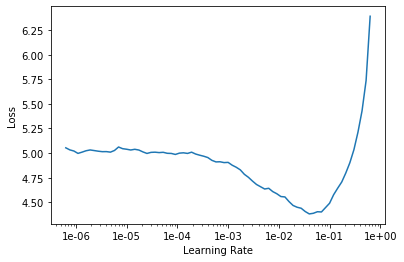

In [9]:
# Learning rate is derived from the slope where we can a clear stable decrease in the loss and usually 1e-3 is a good start for most models
learn.recorder.plot()

In [10]:
#choose the learning rate from the strongest downward slope that is stable. A rule of thumb: the deep layers learning rate is 10 times lower than the shallow layers learning rate
learn.fit_one_cycle(12, slice(1e-3,1e-2))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.841907,1.067277,0.660119,0.339881,03:35
1,0.880709,0.639320,0.826190,0.173810,03:36
2,0.585164,0.324128,0.908631,0.091369,03:33
3,0.404140,0.210951,0.938690,0.061310,03:33
4,0.317149,0.234524,0.938988,0.061012,03:33
5,0.250759,0.175848,0.950893,0.049107,03:37
6,0.231754,0.113987,0.965179,0.034821,03:35
7,0.172871,0.124702,0.963988,0.036012,03:35
8,0.160551,0.097185,0.972917,0.027083,03:35
9,0.126672,0.086730,0.974702,0.025298,03:33


#### evaluate the primary model

In [11]:
interp = ClassificationInterpretation.from_learner(learn)

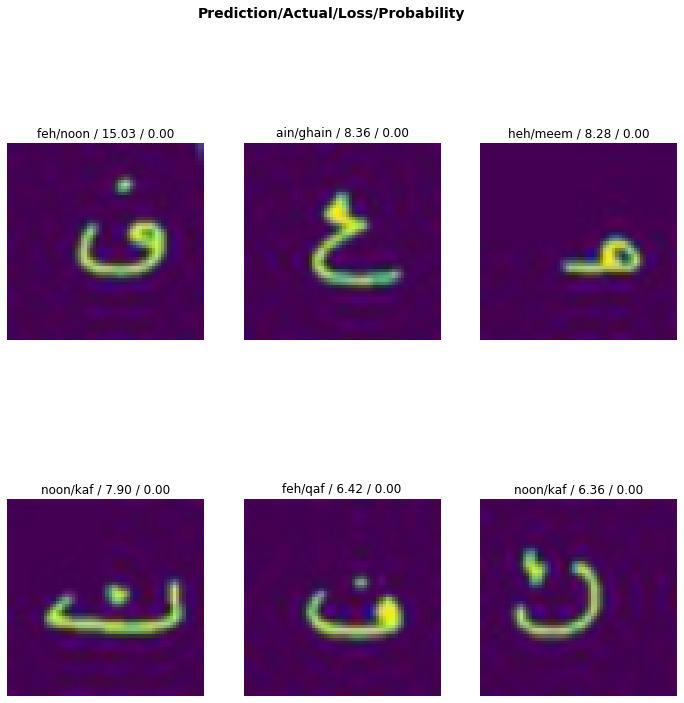

In [12]:
#see images with max loss
interp.plot_top_losses(6)

In [13]:
#in case we need to save the model
#learn.save('stage01-18')

### Stage 2: train the full body

In [14]:
#unfreeze the deep layers, We trained the head and now we traing the full body
learn.unfreeze()

In [15]:
#The fastest I can train this CNN at without making it zip off the rails and blown out. introduce a new learning rate.
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


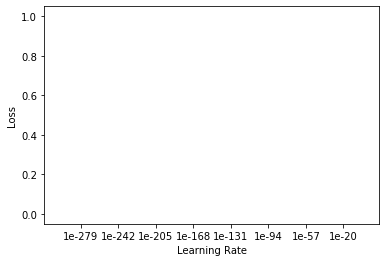

In [16]:
# the learning rate
learn.recorder.plot()

In [17]:
#fit a new model to train the deeper layers
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.119048,0.095226,0.972321,0.027679,05:49
1,0.110910,0.097330,0.972619,0.027381,06:21
2,0.087807,0.076447,0.976786,0.023214,06:29
3,0.067526,0.074042,0.979464,0.020536,07:10


### Stage 3: retrain the full body

The third stage might be too much in this case. We already have very god results. Further computing would only result in small improvment, but with a high computing cost so we might want to stop it here.
Same thing goes for the fine tuning later on, but the aim of this project is to get the highest accuracy possible so I decided to continue regardless of the computing costs.

In [18]:
#learn.lr_find()

In [19]:
#learn.recorder.plot()

In [20]:
#learn.fit_one_cycle(2, max_lr=slice(1e-6))

We save the model

In [21]:
learn.save('AHCR_Resnet-50')

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

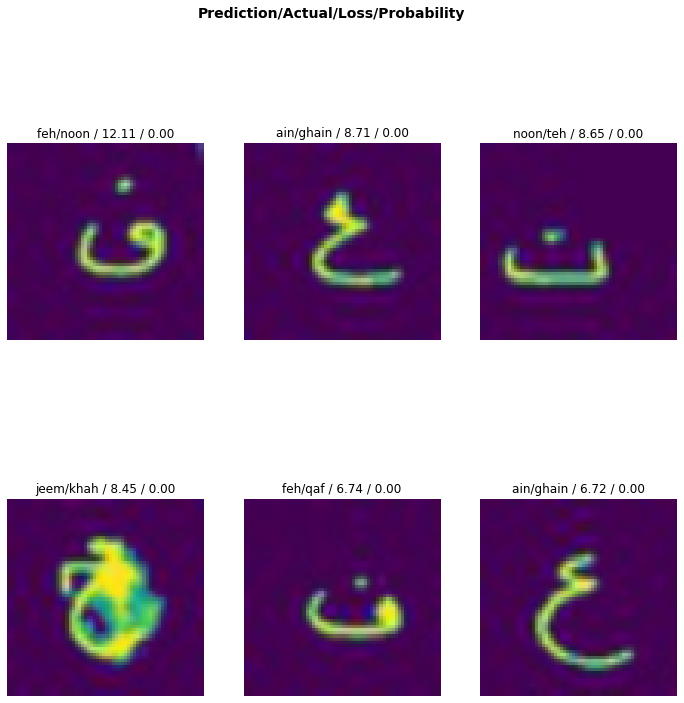

In [23]:
interp.plot_top_losses(6)

In [24]:
interp.most_confused(6)

[('ghain', 'ain', 6)]

In [25]:
# free memory in order to continue the training
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [26]:
import torch

In [27]:
torch.cuda.empty_cache()

In [28]:
from fastai import *
from fastai.vision import *

In [29]:
data_path = Path('data')
input_size = 64
batch_size = 32
arabic_labels = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain', 
                'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']
np.random.seed(42)
tfms = get_transforms(do_flip=False)
s = '([^/\d]+)\d+.jpg$'
data = (ImageList.from_folder(data_path)
        .split_by_rand_pct(0.2)
        .label_from_re(s,classes = arabic_labels)
        .transform(tfms,size=input_size)
        .databunch(bs=batch_size, num_workers=0)
        .normalize(imagenet_stats))

In [30]:
#reload the learner
learn = cnn_learner(data,models.resnet50,metrics=[accuracy, error_rate],pretrained=True)
learn.load('AHCR_Resnet-50')

Learner(data=ImageDataBunch;

Train: LabelList (13440 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
ain,ain,ain,ain,ain
Path: data;

Valid: LabelList (3360 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
dad,sheen,alef,teh,noon
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3,

### Stage 4: Primary validation:

In [31]:
s = '([^/\d]+)\d+.jpg$'
data_test = (ImageList.from_folder(data_path)
        .split_by_folder(train='train', valid='test')
        .label_from_re(s,classes = arabic_labels)
        .transform(tfms,size=input_size)
        .databunch(bs=batch_size, num_workers=0) 
        .normalize(imagenet_stats))
        

tensor = learn.validate(data_test.valid_dl)

In [32]:
tensor

[0.034436386, tensor(0.9908), tensor(0.0092)]

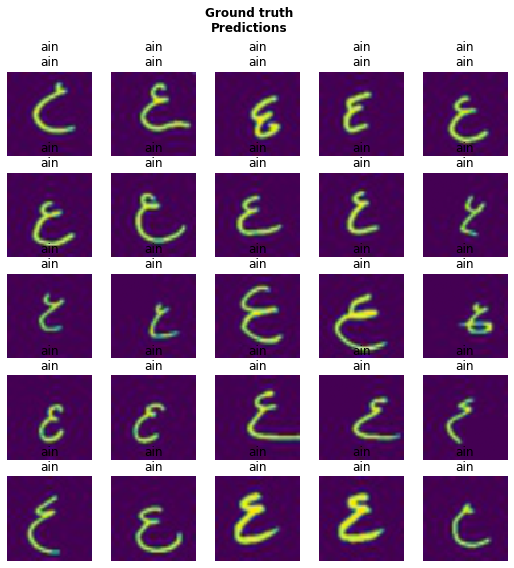

In [33]:
learn.show_results(9, figsize=(9,9))

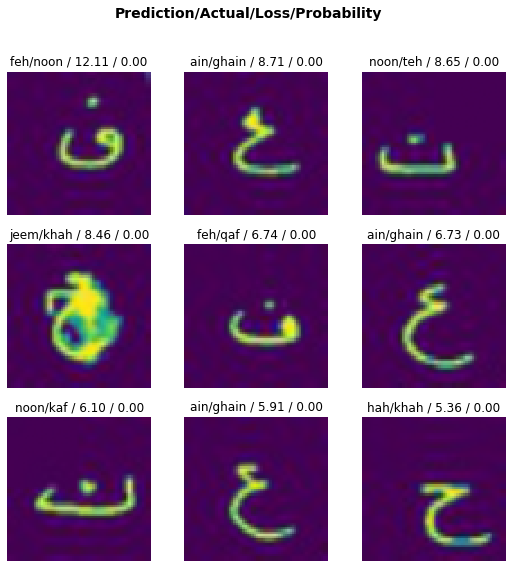

In [34]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_top_losses(9, figsize=(9,9))

In [35]:
# get accuracy
acc = round(float(accuracy(preds, y))*100,2)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 97.95 %.


### Stage 5: Cleaning up

In [36]:
from fastai.widgets import *

### for the training set

In [37]:
ds, idxs = DatasetFormatter().from_toplosses(learn)

In [38]:
ImageCleaner(ds, idxs, data_path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

### for the valid set

In [40]:
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

In [41]:
ImageCleaner(ds, idxs, data_path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

### Stage 6: Train the head after the fine tuning

In [42]:
df = pd.read_csv(data_path/'cleaned.csv', header='infer')
df.head()

,name,label
0,test\ain1043.jpg,ain
1,test\ain1098.jpg,ain
2,test\ain1154.jpg,ain
3,test\ain1155.jpg,ain
4,test\ain1210.jpg,ain


In [43]:
db = (ImageList.from_df(df, data_path)
                   .split_by_rand_pct(0.2)
                   .label_from_df()
                   .transform(get_transforms(do_flip=False), size=input_size)
                   .databunch(bs=batch_size, num_workers=0)).normalize(imagenet_stats)

In [44]:
print(data.classes, data.c, len(data.train_ds), len(data.valid_ds))
print(db.classes, db.c, len(db.train_ds), len(db.valid_ds))

['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal', 'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain', 'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh'] 28 13440 3360
['ain', 'alef', 'beh', 'dad', 'dal', 'feh', 'ghain', 'hah', 'heh', 'jeem', 'kaf', 'khah', 'lam', 'meem', 'noon', 'qaf', 'reh', 'sad', 'seen', 'sheen', 'tah', 'teh', 'thal', 'theh', 'waw', 'yeh', 'zah', 'zain'] 28 10752 2688


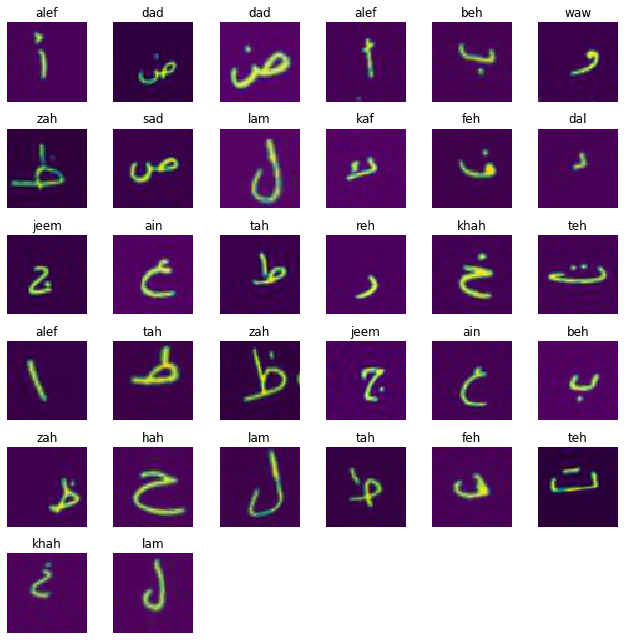

In [45]:
db.show_batch(9, figsize=(9,9))

In [46]:
learn.load('AHCR_Resnet-50')

Learner(data=ImageDataBunch;

Train: LabelList (13440 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
ain,ain,ain,ain,ain
Path: data;

Valid: LabelList (3360 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
dad,sheen,alef,teh,noon
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3,

In [47]:
# replacing the data
learn.data = db 

In [48]:
# We freeze the body back cos we want to train only the head first
learn.freeze()

In [49]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


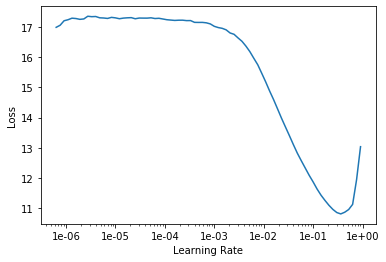

In [50]:
learn.recorder.plot()

In [51]:
learn.fit_one_cycle(4,max_lr=slice(3e-2))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.340478,0.280989,0.926711,0.073289,02:53
1,0.615772,0.238430,0.954613,0.045387,02:40
2,0.285671,0.111037,0.974330,0.025670,02:40
3,0.105957,0.062898,0.984375,0.015625,02:40


### Stage 7: Train the full body again after the fine tuning

In [52]:
# we unfreeze to train the full body again
learn.unfreeze()

In [53]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


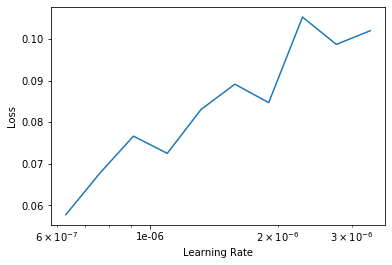

In [54]:
learn.recorder.plot()

In [55]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.147901,0.056835,0.984747,0.015253,04:24
1,0.126458,0.056384,0.987351,0.012649,04:24


In [56]:
interp = ClassificationInterpretation.from_learner(learn)

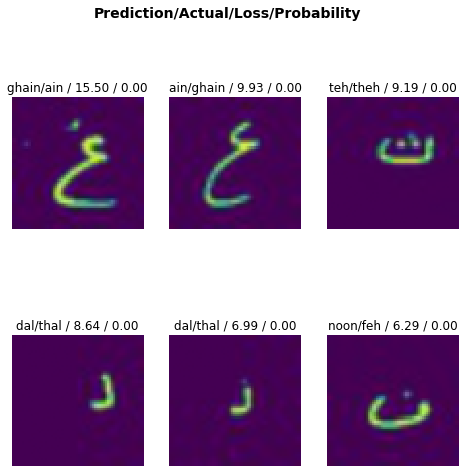

In [57]:
interp.plot_top_losses(6, figsize=(8,8))

In [58]:
learn.save('AHCR_Resnet-50_final')

### Stage 8: Final validation:

In [59]:
#Validate
s = '([^/\d]+)\d+.jpg$'
data_test2 = (ImageList.from_folder(data_path)
        .split_by_folder(train='train', valid='test')
        .label_from_re(s,classes = arabic_labels)
        .transform(tfms,size=input_size)
        .databunch(bs=batch_size, num_workers=0) 
        .normalize(imagenet_stats))
        

tensor = learn.validate(data_test.valid_dl)

In [60]:
tensor

[23.688976, tensor(0.), tensor(1.)]

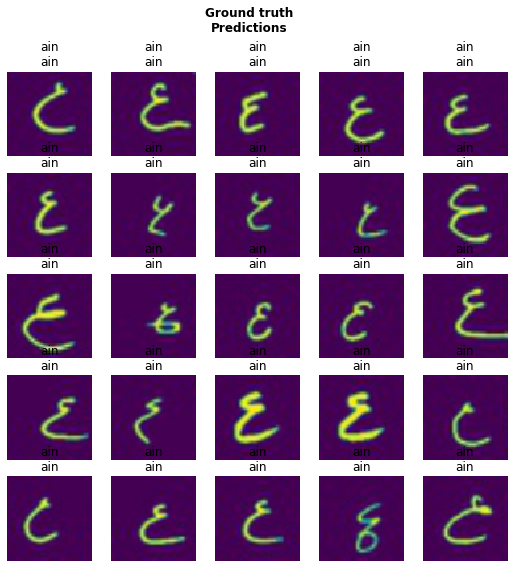

In [61]:
learn.show_results(9, figsize=(9,9))

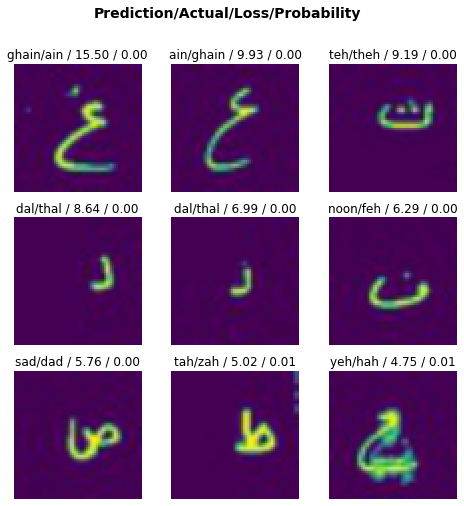

In [62]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_top_losses(9, figsize=(8,8))

In [63]:
# get accuracy
acc = round(float(accuracy(preds, y))*100,2)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 98.74 %.
